In [8]:
import sys
sys.path.append('../')
import numpy as np
from tilted_perovskite_simulation.perovskite import Perovskite
%load_ext line_profiler
%load_ext autoreload
%autoreload 2

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [38]:
tilt_angles = [12,-10,8]
lattice_param = 3.91
atom_species = ["Ca", "Ti", "O"]
uiso = [5.18344632e-03, 2.69926865e-03, 1.04105649e-02]
perovskite = Perovskite(tilt_angles=tilt_angles, lattice_param=lattice_param, atom_species=atom_species, uiso=uiso)

In [39]:
perovskite.save_structure_to_cif('../example.cif')

In [23]:
perovskite.get_structure_dataframe('frac')

,x,y,z,atom_species,uiso
0,0.00,0.00,0.00,Ca,0.005183
1,0.50,0.00,0.00,Ca,0.005183
2,0.00,0.00,0.00,Ca,0.005183
3,0.50,0.00,0.00,Ca,0.005183
4,0.00,0.00,0.50,Ca,0.005183
5,0.50,0.00,0.50,Ca,0.005183
6,0.00,0.00,0.50,Ca,0.005183
7,0.50,0.00,0.50,Ca,0.005183
8,0.25,0.25,0.25,Ti,0.002699
9,0.75,0.25,0.25,Ti,0.002699


In [1]:
import sys
sys.path.append('../')
from tilted_perovskite_simulation.perovskite import Perovskite
from tilted_perovskite_simulation.constants import GLAZER_PARAM
import numpy as np
import os
import random
from typing import *
import multiprocessing as mp
from multiprocessing import Pool, cpu_count
from tqdm import tqdm
from scipy.stats import truncnorm
import matplotlib.pyplot as plt
import pandas as pd

%load_ext line_profiler
%load_ext autoreload
%autoreload 2

# Generate CIF data

In [2]:
GENERAL_GLAZER_PARAM = {
    12: {"x": -1, "y": -2, "z": -3},
    8: {"x": 1, "y": -2, "z": -3},
    4: {"x": 1, "y": 2, "z": -3},
    1: {"x": 1, "y": 2, "z": 3},
}

def calc_general_gm_from_amp(signed_amplitudes: np.array) -> int:
    # Calculate the number of negative values in the amplitudes array
    negative_count = np.sum(signed_amplitudes < 0)
    
    # Iterate through the GLAZER_PARAM dictionary
    for key, value in GENERAL_GLAZER_PARAM.items():
        # Check if the number of negative values in the dictionary entry matches negative_count
        if np.sum(np.array(list(value.values())) < 0) == negative_count:
            return key
    return None  # Return None if no match is found
    
def calc_signed_amplitudes(glazer_system: int, abs_amplitudes: np.array) -> np.array:
    glazer_param_xyz = GLAZER_PARAM[glazer_system]
    
    signed_amplitudes = [
        abs_amplitudes[np.abs(param) - 1] * np.sign(param)
        for param in glazer_param_xyz.values()
    ]
    return np.array(signed_amplitudes)
    
def write_single_cif(args):
    #glazer_system: int
    #signed_amplitudes: np.ndarray
    #lattice_a: float
    #elements: list
    #Uisoequiv: list
    #foldername: str
    #filename: str
    glazer_system, signed_amplitudes, lattice_a, elements, Uisoequiv, foldername, filename = args
    p = Perovskite(lattice_a, elements, Uisoequiv, glazer_system, signed_amplitudes)
    cif_filedir = '{}/{}{}_{:.2f}_{:.2f}_{:.2f}.cif'.format(
        foldername, filename, glazer_system, signed_amplitudes[0], signed_amplitudes[1], signed_amplitudes[2])
    p.save_cif(cif_filedir)
    key = '{}{}_{:.2f}_{:.2f}_{:.2f}'.format(filename, glazer_system, signed_amplitudes[0], signed_amplitudes[1], signed_amplitudes[2])
    return [key, signed_amplitudes[0], signed_amplitudes[1], signed_amplitudes[2]]

In [3]:
def construct_tasks(num_samples: int, 
                    amp_random_params: list,
                    lattice_a: float,
                    elements: list,
                    Uisoequiv: list,
                    foldername: str,
                    filename: str,
                    random_seed: int = 0,
                    ):
    np.random.seed(random_seed)
    if not os.path.exists(foldername):
        os.makedirs(foldername)
    tasks = []
    a, b = (amp_random_params[0] - 0) / amp_random_params[-1], (amp_random_params[1] - 0) / amp_random_params[-1]
    truncated_normal_distribution = truncnorm(a, b, loc=0, scale=amp_random_params[-1])
    for _ in range(num_samples):
        signed_amplitudes = np.array(truncated_normal_distribution.rvs(size=3))
        signed_amplitudes = np.sort(signed_amplitudes)[::-1]
        glazer_system = calc_general_gm_from_amp(signed_amplitudes)
        tasks.append((glazer_system, signed_amplitudes, lattice_a, elements, Uisoequiv, foldername, filename))
    return tasks

In [4]:
num_samples = 100000 # 100,000
lattice_a = 3.91  # lattice parameter in Å
elements = ["Ca", "Ti", "O"]  # in the order of ABX
Uisoequiv = np.array([5.18344632e-03, 2.69926865e-03, 1.04105649e-02])  # in the order of ABX
filename = 'GM'
amp_random_params = [-15, 15, 15] # lower, upper, sigma
foldername = "../data/cif"

tasks = construct_tasks(num_samples, amp_random_params, lattice_a, elements, Uisoequiv, foldername, filename)
with Pool(processes=cpu_count()) as pool:
    data_summary = list(tqdm(pool.imap(write_single_cif, tasks), total=len(tasks)))
np.savetxt(f'../data/data_summary.csv', np.array(data_summary), delimiter=',', fmt='%s')

100%|██████████| 100000/100000 [00:31<00:00, 3153.84it/s]


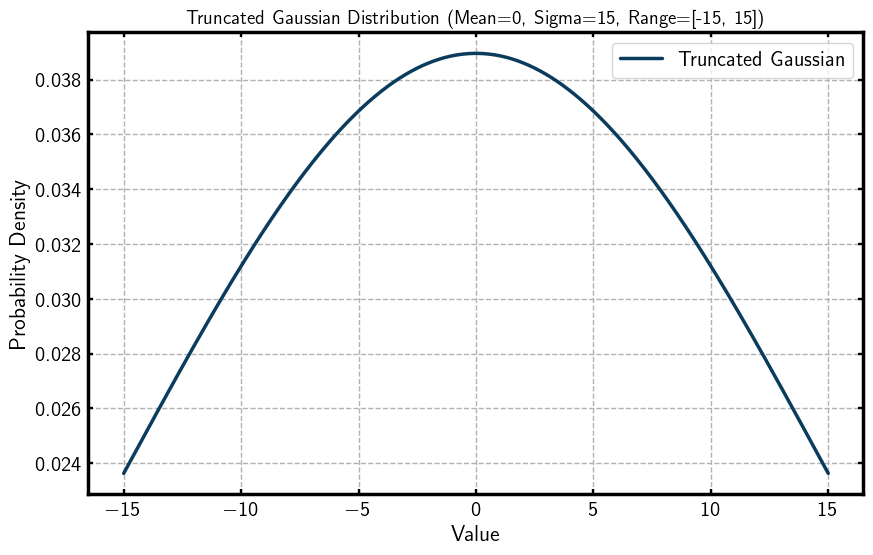

In [6]:
# plot the random number distribution
from bg_mpl_stylesheet.bg_mpl_stylesheet import bg_mpl_style
plt.style.use(bg_mpl_style)
lower, upper = -15, 15
sigma = 15
a, b = (lower - 0) / sigma, (upper - 0) / sigma
truncated_normal_distribution = truncnorm(a, b, loc=0, scale=sigma)
x = np.linspace(lower, upper, 1000)
y = truncated_normal_distribution.pdf(x)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(x, y, label='Truncated Gaussian')
plt.title('Truncated Gaussian Distribution (Mean=0, Sigma=15, Range=[-15, 15])')
plt.xlabel('Value')
plt.ylabel('Probability Density')
plt.grid(True)
plt.legend()
plt.show()

# Generate PDF data

In [8]:
import sys
sys.path.append('../')
import numpy as np
import os
import glob
from pathlib import Path
from diffpy.Structure import loadStructure
from diffpy.srreal.pdfcalculator import PDFCalculator
from pathlib import Path
from sympy import *
from typing import *
from glazer_mode_mining.data_utils import write_single_pdf

In [9]:
def construct_tasks(cif_folder_dir: str, pdf_folder_dir: str, pc_cfg_range: dict):
    if not os.path.exists(pdf_folder_dir):
        os.makedirs(pdf_folder_dir)
    tasks = []
    for cif_file_dir in glob.glob("{}/*.cif".format(cif_folder_dir)):
        random_pc_cfg = {key: random.uniform(*value) for key, value in pc_cfg_range.items()}
        cif_file_name = os.path.basename(cif_file_dir)
        pdf_file_dir = Path(pdf_folder_dir, cif_file_name).with_suffix(".gr")
        tasks.append((cif_file_dir, pdf_file_dir, random_pc_cfg))
    return tasks

In [10]:
pc_cfg_range = {
    "rmax": [25, 30],
    "rstep": [0.01, 0.01],
    "qmin": [0.5, 0.5],
    "qmax": [20,25],
    "qdamp": [0, 0.05],
    "qbroad": [0.01, 0.01],
    "delta2": [2.1, 2.1],
}
cif_folder_dir = '../data/cif'
pdf_folder_dir = '../data/pdf'

mp.set_start_method('spawn', force=True)
tasks = construct_tasks(cif_folder_dir, pdf_folder_dir, pc_cfg_range)
with Pool(processes=cpu_count()) as pool:
    data_summary_pdf = list(tqdm(pool.imap(write_single_pdf, tasks), total=len(tasks)))
    
column_names = ['filename'] + list(pc_cfg_range.keys())
df = pd.DataFrame(data_summary_pdf, columns=column_names)
df.to_csv('../data/data_summary_pdf.csv', index=False)

100%|██████████| 100000/100000 [1:03:27<00:00, 26.26it/s]


# Symmetry Breaking Measure

In [30]:
lattice_a = 3.91  # lattice parameter in Å
elements = ["Ca", "Ti", "O"]  # in the order of ABX
Uisoequiv = np.array([5.18344632e-03, 2.69926865e-03, 1.04105649e-02])  # in the order of ABX
glazer_system = 21
amplitudes_max= 20
filename = 'GM'
foldername = "../data/cif_sbm"

In [33]:
for amp in range(amplitudes_max + 1):
    signed_amplitudes = [0, 0, amp]
    p = Perovskite(lattice_a, elements, Uisoequiv, glazer_system, signed_amplitudes)
    cif_filedir = '{}/sbm_{}{}_{}_{}_{}_{}.cif'.format(
        foldername, filename, glazer_system, amp, signed_amplitudes[0], signed_amplitudes[1], signed_amplitudes[2])
    p.save_cif(cif_filedir)

# Experimental Data

### Sandra's Prediction

In [17]:
lattice_a = 3.91  # lattice parameter in Å
elements = ["Ca", "Ti", "O"]  # in the order of ABX
Uisoequiv = np.array([5.18344632e-03, 2.69926865e-03, 1.04105649e-02])  # in the order of ABX
filename = 'GM'
amp_range = [-15, 15]
foldername = "../data/real"
signed_amplitudes = np.array([7.6, -9.7, -9.7])
glazer_system = calc_general_gm_from_amp(signed_amplitudes)
args = (glazer_system, signed_amplitudes, lattice_a, elements, Uisoequiv, foldername, filename)

tasks = construct_tasks(num_samples, amp_range, lattice_a, elements, Uisoequiv, foldername, filename)
write_single_cif(args)

['GM8_7.60_-9.70_-9.70', 7.6, -9.7, -9.7]

### My Prediction

In [16]:
lattice_a = 3.91  # lattice parameter in Å
elements = ["Ca", "Ti", "O"]  # in the order of ABX
Uisoequiv = np.array([5.18344632e-03, 2.69926865e-03, 1.04105649e-02])  # in the order of ABX
filename = 'GM'
amp_range = [-15, 15]
foldername = "../data/real"
#signed_amplitudes = np.array([10.49237, 6.6551566, -11.7556925])
signed_amplitudes = np.array([11.98727, 8.341632, -11.547309])

glazer_system = calc_general_gm_from_amp(signed_amplitudes)
args = (glazer_system, signed_amplitudes, lattice_a, elements, Uisoequiv, foldername, filename)

tasks = construct_tasks(num_samples, amp_range, lattice_a, elements, Uisoequiv, foldername, filename)
write_single_cif(args)

['GM4_11.99_8.34_-11.55', 11.98727, 8.341632, -11.547309]

### Generate PDF

In [18]:
from glazer_mode_mining.data_utils import write_multiple_pdf
pc_cfg = {
    "rmax": 30,
    "rstep": 0.01,
    "qmin": 0.6,
    "qmax": 23.6,
    "qdamp": 0.0291601718936,
    "qbroad": 0.0103215402787,
    "delta2": 2.1261,
}
write_multiple_pdf('../data/real', '../data/real', pc_cfg)